In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import h5py
import math
import timm
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
import random
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, recall_score
from sklearn.tree import DecisionTreeClassifier
from tqdm import tqdm
from scipy.ndimage import binary_dilation, binary_erosion
from torch.utils.data import TensorDataset, DataLoader
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
folder_path= "/data_g1/AI_projects/raw_data/PCITB_CRC"

/home/jantao/sequoia-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [34]:
# relevant csv preview
map_path= os.path.join(folder_path, "map_fnms_TMAcoor_tumorIDs_level1_16_rmYALE.csv")
map_df= pd.read_csv(map_path)
map_df

,TMA_XY,X,Y,ID,TMA.x,fnm,TMA.y,coor,level,coorX,coorY,coorXY,tumor,data_id
0,TMA1_1_10,1,10,T82-4T,TMA1,"TMA 1 Level 16_Core[1,1,10]_[4381,47584].tif.txt",TMA1,1_10,16,1,10,1_10,82,"TMA 1 Level 16_Core[1,1,10]_[4381,47584]"
1,TMA1_1_10,1,10,T82-4T,TMA1,"TMA 1 Level 1_Core[1,1,10]_[3229,44466].tif.txt",TMA1,1_10,1,1,10,1_10,82,"TMA 1 Level 1_Core[1,1,10]_[3229,44466]"
2,TMA1_1_12,1,12,T97-1T,TMA1,"TMA 1 Level 1_Core[1,1,12]_[3031,46487].tif.txt",TMA1,1_12,1,1,12,1_12,97,"TMA 1 Level 1_Core[1,1,12]_[3031,46487]"
3,TMA1_1_12,1,12,T97-1T,TMA1,"TMA 1 Level 16_Core[1,1,12]_[4134,49464].tif.txt",TMA1,1_12,16,1,12,1_12,97,"TMA 1 Level 16_Core[1,1,12]_[4134,49464]"
4,TMA1_1_13,1,13,T104-2T,TMA1,"TMA 1 Level 1_Core[1,1,13]_[3344,47029].tif.txt",TMA1,1_13,1,1,13,1_13,104,"TMA 1 Level 1_Core[1,1,13]_[3344,47029]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3216,TMA6_9_13,9,13,T1782,TMA6,"TMA 6 Level 1_Core[1,9,13]_[7794,43876].tif.txt",TMA6,9_13,1,9,13,9_13,1782,"TMA 6 Level 1_Core[1,9,13]_[7794,43876]"
3217,TMA6_9_2,9,2,T1749,TMA6,"TMA 6 Level 1_Core[1,9,2]_[17735,43950].tif.txt",TMA6,9_2,1,9,2,9_2,1749,"TMA 6 Level 1_Core[1,9,2]_[17735,43950]"
3218,TMA6_9_3,9,3,T1753,TMA6,"TMA 6 Level 1_Core[1,9,3]_[16820,43975].tif.txt",TMA6,9_3,1,9,3,9_3,1753,"TMA 6 Level 1_Core[1,9,3]_[16820,43975]"
3219,TMA6_9_7,9,7,T1760,TMA6,"TMA 6 Level 1_Core[1,9,7]_[13284,43876].tif.txt",TMA6,9_7,1,9,7,9_7,1760,"TMA 6 Level 1_Core[1,9,7]_[13284,43876]"


In [3]:
# relevant csv preview
csv_path= os.path.join(folder_path, "data_he20190613.csv")
df= pd.read_csv(csv_path)
tumour_id= df["TumorID"].to_list()
print(len(sorted(tumour_id)))
#df

934


In [2]:
# main functions
def preprocess(folder_path):    
    map_path= os.path.join(folder_path, "map_fnms_TMAcoor_tumorIDs_level1_16_rmYALE.csv")
    map_df= pd.read_csv(map_path)
    gt_path= os.path.join(folder_path, "data_he20190613.csv")
    gt_df= pd.read_csv(gt_path)
    map_df["tumor"]= map_df["tumor"].astype(str)
    gt_df["TumorID"]= gt_df["TumorID"].astype(str)
    map_df_filtered = map_df[map_df["tumor"].isin(gt_df["TumorID"])].copy()
    aligned_df = map_df_filtered.merge(
        gt_df[["TumorID", "msin"]],
        left_on="tumor",
        right_on="TumorID",
        how="left"
    ).drop(columns= ["TumorID"])
    aligned_df["fnm"] = aligned_df["fnm"].str.replace(r"\.txt$", "", regex=True)
    aligned_df= aligned_df.dropna(how= "any")
    patients = aligned_df["tumor"].unique()
    labels= aligned_df.groupby("tumor")["msin"].first().loc[patients]
    train_patients, test_patients = train_test_split(
        patients,
        test_size=0.2,
        stratify=labels,
        random_state= 42
    )
    train_df_full = aligned_df[aligned_df["tumor"].isin(train_patients)].copy()
    test_df = aligned_df[aligned_df["tumor"].isin(test_patients)].copy()
    skf = StratifiedKFold(n_splits= 5, shuffle=True, random_state= 42)
    train_labels = train_df_full.groupby("tumor")["msin"].first().loc[train_patients]
    folds= []
    train_patients= np.array(train_patients)
    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(train_patients, train_labels)):
        fold_train_patients = train_patients[train_idx]
        fold_val_patients   = train_patients[val_idx]    
        train_df = train_df_full[train_df_full["tumor"].isin(fold_train_patients)].copy()
        val_df   = train_df_full[train_df_full["tumor"].isin(fold_val_patients)].copy()    
        folds.append((train_df, val_df))
        print(f"Fold {fold_idx+1}: train {len(fold_train_patients)} patients, val {len(fold_val_patients)} patients")
    
    print(f"Hold-out test set: {len(test_patients)} patients")
    
    return folds, test_df
    
def generate_mask(save_dir, threshold=220):
    base_path= "/data_g1/AI_projects/raw_data/PCITB_CRC/HE_raw_images/Tumor"
    os.makedirs(save_dir, exist_ok=True)
    map_path= os.path.join(folder_path, "map_fnms_TMAcoor_tumorIDs_level1_16_rmYALE.csv")
    map_df= pd.read_csv(map_path)
    map_df["fnm"] = map_df["fnm"].str.replace(r"\.txt$", "", regex=True)
    
    for index, row in tqdm(map_df.iterrows(), total=len(map_df)):
        image_name= row["fnm"]
        folder_name= row["TMA.x"]
        full_path= os.path.join(base_path, folder_name, image_name)
        img = Image.open(full_path).convert("RGB")
        gray = np.array(img.convert("L"))
        mask = (gray < threshold)   
        mask = binary_dilation(mask, iterations=3)
        mask = binary_erosion(mask, iterations=3)
        mask = (mask.astype(np.uint8) * 255)
        name, _ = os.path.splitext(image_name)
        mask_filename = f"{name}_mask.png"
        mask_save_path = os.path.join(save_dir, mask_filename)    
        mask_img = Image.fromarray(mask)
        mask_img.save(mask_save_path)

    return
    
def patch_extraction(folds, test_df, folder_path, save_path, patch_size, max_samples, mask_folder):
    with h5py.File(save_path, "w") as h5f:
        for fold_idx, (train_df, val_df) in enumerate(folds):
            
            for split_name, df in[("train", train_df), ("val", val_df)]:
                group= h5f.require_group(f"fold_{fold_idx}/{split_name}")
                patch_extraction_helper(df, group, folder_path, patch_size, max_samples, mask_folder)

        test_group= h5f.require_group("test")
        patch_extraction_helper(test_df, test_group, folder_path, patch_size, max_samples, mask_folder)

    return
    
def patch_extraction_helper(df, group, folder_path, patch_size, max_samples, mask_folder):
    iterator= df.iterrows()
    total_rows= len(df)
    
    if max_samples is not None:
        iterator= list(df.iterrows())[: max_samples]
        total_rows= len(iterator)
        
    for index, row in tqdm(iterator, total= total_rows):
        tumour_id= str(row["tumor"])
        tma_folder= str(row["TMA.x"])
        core_name = os.path.splitext(row["fnm"])[0]
        core_group= group.require_group(core_name)
        image_path= os.path.join(folder_path, "HE_raw_images/Tumor", tma_folder, row["fnm"])
        img= Image.open(image_path).convert("RGB")
        mask_name= core_name+ "_mask.png"
        mask_path= os.path.join(mask_folder, mask_name)
        mask= Image.open(mask_path).convert("L")
        w, h= img.size
        nx, ny= w// patch_size, h// patch_size
        patches= []
        coords= []
        
        for yi in range(ny):
            for xi in range(nx):
                left, upper= xi* patch_size, yi* patch_size 
                right, lower= left+ patch_size, upper+ patch_size 
                patch = img.crop((left, upper, right, lower))
                mask_patch= mask.crop((left, upper, right, lower))
                tissue_ratio= (np.array(mask_patch)> 0).mean()
                
                if tissue_ratio>= 0.2:
                    patches.append(np.array(patch, dtype= np.uint8))
                    coords.append((left, upper))
                    
        if len(patches)> 0:
            patches= np.stack(patches, axis= 0)
            coords= np.array(coords, dtype= np.int32)
            core_group.create_dataset("patches", data=patches, compression="gzip")
            core_group.create_dataset("coords", data=coords, compression="gzip")
            core_group.attrs["tumor"] = tumour_id
            core_group.attrs["original_image"] = row["fnm"]
            
        else:
            print(f"This image does not have any valid patches: {core_name}")
        
    return
    
def feature_extraction(folds, test_df, patch_h5_path, feature_h5_path, model, batch_size):
    transform= T.Compose([
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std= [0.229, 0.224, 0.225])
    ])
    
    with h5py.File(patch_h5_path, "r") as patch_h5, h5py.File(feature_h5_path, "w") as feat_h5:
        for fold_idx, (train_df, val_df) in enumerate(folds):
            
            for split_name, df in [("train", train_df), ("val", val_df)]:
                split_group = feat_h5.require_group(f"fold_{fold_idx}/{split_name}")
                feature_extraction_helper(df, split_group, patch_h5, fold_idx, split_name, model, transform, batch_size)

        test_group= feat_h5.require_group("test")
        feature_extraction_helper(test_df, test_group, patch_h5, None, "test", model, transform, batch_size)

    return
    
def feature_extraction_helper(df, group, patch_h5, fold_idx, split_name, model, transform, batch_size):
    df["core_name"] = df["fnm"].apply(lambda x: os.path.splitext(x)[0])
    cores = df.groupby("core_name")
    
    for core_name, core_df in tqdm(cores, total= len(cores)):
        if fold_idx is not None:
            patch_path = f"fold_{fold_idx}/{split_name}/{core_name}/patches"
            
        else:
            patch_path= f"test/{core_name}/patches"

        if patch_path not in patch_h5:
            print(f"Skipping core {core_name}: path not found in HDF5")
            continue
            
        patches= patch_h5[patch_path][:]    
        n = patches.shape[0]
        core_features = []
        
        for i in range(0, n, batch_size):
            batch = patches[i:i+batch_size]
            batch_tensors = torch.stack([transform(Image.fromarray(p)) for p in batch]).to(device)
            
            with torch.no_grad():
                feats = model(batch_tensors)
            
            core_features.append(feats.cpu().numpy())
        
        core_features = np.concatenate(core_features, axis=0)
        core_feature_vector = core_features.mean(axis=0)
        core_group = group.require_group(core_name)
        core_group.create_dataset("features", data=core_feature_vector, compression="gzip")
        core_group.attrs["tumor"] = core_df["tumor"].iloc[0]
        core_group.attrs["original_image"] = core_df["fnm"].iloc[0]
        
    print(f"{split_name}: {len(cores)} cores processed")
    
    return

def patient_aggregation(core_feat_h5_path, strategy, patient_feat_h5_path):
    with h5py.File(core_feat_h5_path, "r") as core_h5, h5py.File(patient_feat_h5_path, "w") as patient_h5:
        

        for group_key in core_h5.keys():
            core_group_top = core_h5[group_key]
            patient_group_top = patient_h5.require_group(group_key)
            
            if group_key.startswith("fold_"):
                splits= core_group_top.keys()
                
            else:
                splits= [group_key]
                
            for split_key in splits:
                if group_key.startswith("fold_"):
                    split_group = core_group_top[split_key]
                    patient_split_group = patient_group_top.require_group(split_key)
                    
                else:
                    split_group= core_group_top
                    patient_split_group= patient_group_top
                
                # Collect features per patient
                patient_dict = {}
                for core_name in split_group.keys():
                    core_group = split_group[core_name]
                    patient_id = core_group.attrs.get("tumor", None)
                    
                    if patient_id is None:
                        print(f"Warning: core {core_name} missing 'tumor' attribute, skipping")
                        continue
                        
                    features = core_group["features"][:]                    
                    if patient_id not in patient_dict:
                        patient_dict[patient_id] = []
                    patient_dict[patient_id].append(features)
                
                # Aggregate per patient
                for patient_id, core_feats in patient_dict.items():
                    core_feats = np.stack(core_feats, axis=0)
                    
                    if strategy == "mean":
                        patient_feats = core_feats.mean(axis=0)
                    elif strategy == "max":
                        patient_feats = core_feats.max(axis=0)
                    elif strategy == "mean_max":
                        patient_feats = np.concatenate([core_feats.mean(axis=0), core_feats.max(axis=0)])
                    else:
                        raise ValueError(f"Unknown aggregation strategy: {strategy}")
                    
                    # Save to HDF5
                    p_group = patient_split_group.require_group(str(patient_id))
                    p_group.create_dataset("features", data=patient_feats, compression="gzip")
                    p_group.attrs["num_cores"] = core_feats.shape[0]
                    
                print(f"{group_key}/{split_key}: aggregated {len(patient_dict)} patients with strategy={strategy}")
                
    print(f"Patient-level embeddings saved to {patient_feat_h5_path}")
    
    return
                     
def load_embeddings(folder_path, h5_path):
    csv_path= os.path.join(folder_path, "data_he20190613.csv")
    df= pd.read_csv(csv_path)
    df["TumorID"] = df["TumorID"].astype(str)
    label_map = df.set_index("TumorID")["msin"].to_dict()
    folds, test= {}, {}
    
    with h5py.File(h5_path, "r") as f:
        for group_name in f.keys():
            group= f[group_name]
            if group_name.startswith("fold_"):
                folds[group_name] = {}
                for split in ["train", "val"]:
                    X_list, y_list, ids = [], [], []
                    for pid in group[split].keys():
                        feats = np.array(group[split][pid]["features"][:])
                        if feats.ndim > 1:
                            feats = feats.reshape(-1)  # flatten if needed

                        pid_str = str(pid)
                        
                        if pid_str in label_map:
                            X_list.append(feats)
                            y_list.append(int(label_map[pid_str]))
                            ids.append(pid_str)
                            
                        else:
                            print(f"No label for TumorID {pid_str} in {group_name}/ {split}.")

                    folds[group_name][split] = {
                        "X": np.stack(X_list).astype(np.float32),
                        "y": np.array(y_list, dtype=np.int64),
                        "ids": ids
                    }

            # If test group
            elif group_name == "test":
                X_list, y_list, ids = [], [], []
                for pid in group.keys():
                    feats = np.array(group[pid]["features"][:])
                    if feats.ndim > 1:
                        feats = feats.reshape(-1)

                    pid_str = str(pid)
                    
                    if pid_str in label_map:
                        X_list.append(feats)
                        y_list.append(int(label_map[pid_str]))
                        ids.append(pid_str)
                        
                    else:
                        print(f"No label for TumorID {pid_str} in test.")

                test= {    
                    "X": np.stack(X_list).astype(np.float32),
                    "y": np.array(y_list, dtype=np.int64),
                    "ids": ids
                }
                
    return folds, test

In [30]:
folds, test_df= preprocess(folder_path)

Fold 1: train 580 patients, val 145 patients
Fold 2: train 580 patients, val 145 patients
Fold 3: train 580 patients, val 145 patients
Fold 4: train 580 patients, val 145 patients
Fold 5: train 580 patients, val 145 patients
Hold-out test set: 182 patients


In [27]:
generate_mask("/home/jantao/MSI_prediction/uni_masks")

100%|███████████████████████████████████████████████████████████████████████████████| 3221/3221 [07:32<00:00,  7.12it/s]


In [39]:
patch_extraction(folds, test_df, folder_path, "better_patches.h5", 224, None, "/home/jantao/MSI_prediction/uni_masks")

 32%|█████████████████████████▋                                                      | 586/1829 [01:30<02:45,  7.50it/s]

This image does not have any valid patches: TMA 12 Level 1_Core[1,19,2]_[19157,36297]


 33%|██████████████████████████▏                                                     | 601/1833 [01:33<02:44,  7.49it/s]

This image does not have any valid patches: TMA 12 Level 1_Core[1,19,2]_[19157,36297]


 31%|████████████████████████▊                                                       | 565/1819 [01:27<02:45,  7.57it/s]

This image does not have any valid patches: TMA 12 Level 1_Core[1,19,2]_[19157,36297]


 30%|████████████████████████▎                                                       | 560/1847 [01:26<02:53,  7.43it/s]

This image does not have any valid patches: TMA 12 Level 1_Core[1,19,2]_[19157,36297]


 30%|████████████████████████▎                                                        | 134/446 [00:20<00:41,  7.58it/s]

This image does not have any valid patches: TMA 12 Level 1_Core[1,19,2]_[19157,36297]


 74%|███████████████████████████████████████████████████████████▋                     | 430/583 [01:09<00:17,  8.72it/s]

This image does not have any valid patches: TMA 2 Level 1_Core[2,6,10]_[12602,42576]


100%|█████████████████████████████████████████████████████████████████████████████████| 583/583 [01:34<00:00,  6.17it/s]


In [3]:
# feature extraction
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
local_dir = "/home/jantao/UNI"
ckpt_path = os.path.join(local_dir, "pytorch_model.bin")
model = timm.create_model(
    "vit_large_patch16_224",
    img_size=224,
    patch_size=16,
    init_values=1e-5,
    num_classes=0,
    dynamic_img_size=True
)
state_dict = torch.load(ckpt_path, map_location="cpu")
model.load_state_dict(state_dict, strict=True)
model = model.to(device)
model.eval()
folds, test_df= preprocess(folder_path)
#feature_extraction(folds, test_df, "patches.h5", "features.h5", model, 16)
feature_extraction(folds, test_df, "/home/jantao/MSI_prediction/better_patches.h5", "/home/jantao/MSI_prediction/better_uni_features.h5", model, 16)

cuda:0
Fold 1: train 580 patients, val 145 patients
Fold 2: train 580 patients, val 145 patients
Fold 3: train 580 patients, val 145 patients
Fold 4: train 580 patients, val 145 patients
Fold 5: train 580 patients, val 145 patients
Hold-out test set: 182 patients


 33%|██████████████████████████▍                                                     | 604/1829 [01:59<04:05,  4.99it/s]

Skipping core TMA 12 Level 1_Core[1,19,2]_[19157,36297]: path not found in HDF5


100%|███████████████████████████████████████████████████████████████████████████████| 1829/1829 [06:22<00:00,  4.78it/s]


train: 1829 cores processed


100%|█████████████████████████████████████████████████████████████████████████████████| 465/465 [01:38<00:00,  4.73it/s]


val: 465 cores processed


 34%|███████████████████████████▏                                                    | 622/1833 [02:06<03:11,  6.33it/s]

Skipping core TMA 12 Level 1_Core[1,19,2]_[19157,36297]: path not found in HDF5


100%|███████████████████████████████████████████████████████████████████████████████| 1833/1833 [06:26<00:00,  4.75it/s]


train: 1833 cores processed


100%|█████████████████████████████████████████████████████████████████████████████████| 461/461 [01:36<00:00,  4.76it/s]


val: 461 cores processed


 32%|█████████████████████████▋                                                      | 585/1819 [01:58<04:01,  5.11it/s]

Skipping core TMA 12 Level 1_Core[1,19,2]_[19157,36297]: path not found in HDF5


100%|███████████████████████████████████████████████████████████████████████████████| 1819/1819 [06:21<00:00,  4.76it/s]


train: 1819 cores processed


100%|█████████████████████████████████████████████████████████████████████████████████| 475/475 [01:40<00:00,  4.74it/s]


val: 475 cores processed


 31%|█████████████████████████                                                       | 579/1847 [01:56<03:12,  6.59it/s]

Skipping core TMA 12 Level 1_Core[1,19,2]_[19157,36297]: path not found in HDF5


100%|███████████████████████████████████████████████████████████████████████████████| 1847/1847 [06:26<00:00,  4.78it/s]


train: 1847 cores processed


100%|█████████████████████████████████████████████████████████████████████████████████| 447/447 [01:34<00:00,  4.73it/s]


val: 447 cores processed


100%|███████████████████████████████████████████████████████████████████████████████| 1848/1848 [06:28<00:00,  4.76it/s]


train: 1848 cores processed


 30%|████████████████████████▋                                                        | 136/446 [00:27<01:00,  5.15it/s]

Skipping core TMA 12 Level 1_Core[1,19,2]_[19157,36297]: path not found in HDF5


100%|█████████████████████████████████████████████████████████████████████████████████| 446/446 [01:32<00:00,  4.84it/s]


val: 446 cores processed


 75%|████████████████████████████████████████████████████████████▍                    | 435/583 [01:30<00:18,  8.01it/s]

Skipping core TMA 2 Level 1_Core[2,6,10]_[12602,42576]: path not found in HDF5


100%|█████████████████████████████████████████████████████████████████████████████████| 583/583 [02:02<00:00,  4.77it/s]

test: 583 cores processed


In [4]:
strategy= "mean"
#patient_aggregation("features.h5", strategy, f"{strategy}_aggregated_features.h5")
patient_aggregation("better_uni_features.h5", strategy, f"{strategy}_aggregated_better_uni_features.h5")

fold_0/train: aggregated 580 patients with strategy=mean
fold_0/val: aggregated 145 patients with strategy=mean
fold_1/train: aggregated 580 patients with strategy=mean
fold_1/val: aggregated 145 patients with strategy=mean
fold_2/train: aggregated 580 patients with strategy=mean
fold_2/val: aggregated 145 patients with strategy=mean
fold_3/train: aggregated 580 patients with strategy=mean
fold_3/val: aggregated 145 patients with strategy=mean
fold_4/train: aggregated 580 patients with strategy=mean
fold_4/val: aggregated 145 patients with strategy=mean
test/test: aggregated 182 patients with strategy=mean
Patient-level embeddings saved to mean_aggregated_better_uni_features.h5


In [3]:
#folds, test = load_embeddings(folder_path, "mean_aggregated_features.h5")
folds, test = load_embeddings(folder_path, "mean_aggregated_better_uni_features.h5")
print(f"Available folds: {list(folds.keys())}")
print("Fold 0 train shape:", folds["fold_0"]["train"]["X"].shape)
print("Fold 0 val shape:", folds["fold_0"]["val"]["X"].shape)
print("Test shape:", test["X"].shape)

Available folds: ['fold_0', 'fold_1', 'fold_2', 'fold_3', 'fold_4']
Fold 0 train shape: (580, 1024)
Fold 0 val shape: (145, 1024)
Test shape: (182, 1024)


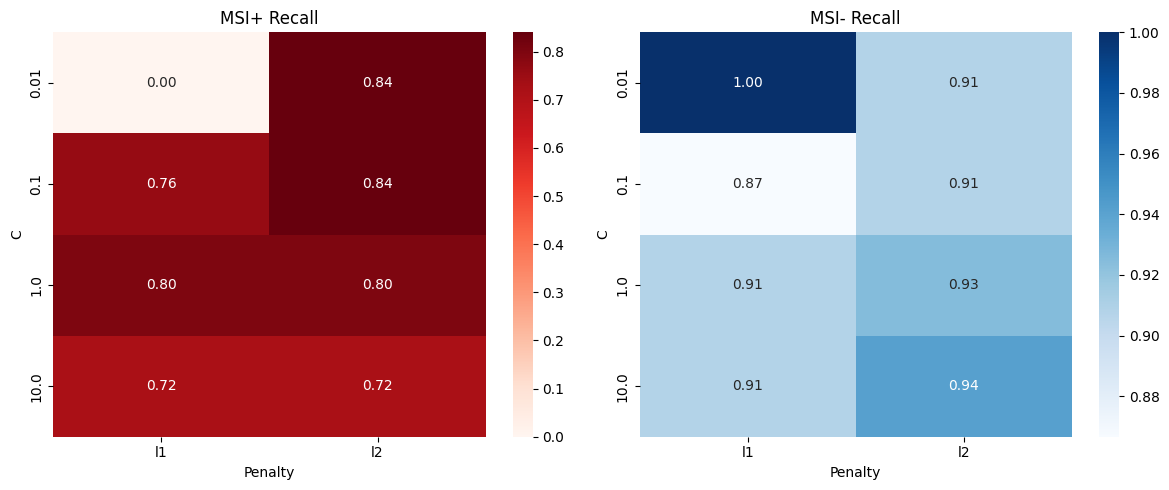

In [16]:
# logistic regression, grid search for hyperparameters
X_train_grid = folds["fold_0"]["train"]["X"]
y_train_grid = folds["fold_0"]["train"]["y"]

X_val_grid = folds["fold_0"]["val"]["X"]
y_val_grid = folds["fold_0"]["val"]["y"]

# Step 1a: Grid search on training folds
C_list = [0.01, 0.1, 1, 10]
penalties = ["l1", "l2"]

# Store recall for each combination
recall_pos = np.zeros((len(C_list), len(penalties)))  # MSI+ recall
recall_neg = np.zeros((len(C_list), len(penalties)))  # MSI- recall

for i, C in enumerate(C_list):
    for j, penalty in enumerate(penalties):
        lr = LogisticRegression(max_iter=1000, class_weight="balanced", C=C, penalty=penalty, solver="liblinear")
        lr.fit(X_train_grid, y_train_grid)
        y_pred = lr.predict(X_val_grid)
        recall_pos[i, j] = recall_score(y_val_grid, y_pred, pos_label=1)
        recall_neg[i, j] = recall_score(y_val_grid, y_pred, pos_label=0)

# Convert to DataFrames for easier plotting
recall_pos_df = pd.DataFrame(recall_pos, index=C_list, columns=penalties)
recall_neg_df = pd.DataFrame(recall_neg, index=C_list, columns=penalties)

# Plot heatmaps
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(recall_pos_df, annot=True, fmt=".2f", cmap="Reds")
plt.title("MSI+ Recall")
plt.xlabel("Penalty")
plt.ylabel("C")
plt.subplot(1, 2, 2)
sns.heatmap(recall_neg_df, annot=True, fmt=".2f", cmap="Blues")
plt.title("MSI- Recall")
plt.xlabel("Penalty")
plt.ylabel("C")
plt.tight_layout()
plt.show()

In [23]:
# logistic regression, 5 fold validation
n_folds = 5
val_metrics = {"accuracy": [], "roc_auc": [], "recall": []}
all_y_true = []
all_y_pred = []
for fold in range(n_folds):
    fold_key = f"fold_{fold}"
    X_train = folds[fold_key]["train"]["X"]
    y_train = folds[fold_key]["train"]["y"]
    X_val   = folds[fold_key]["val"]["X"]
    y_val   = folds[fold_key]["val"]["y"]

    # train model
    lr = LogisticRegression(max_iter=1000, class_weight="balanced", penalty= "l2", C= 0.1, solver= "liblinear")
    lr.fit(X_train, y_train)

    # predict probabilities and labels
    y_prob = lr.predict_proba(X_val)[:, 1]
    y_pred = (y_prob >= 0.15).astype(int)  # threshold can be tuned later

    # collect metrics
    val_metrics["accuracy"].append(accuracy_score(y_val, y_pred))
    val_metrics["roc_auc"].append(roc_auc_score(y_val, y_prob))
    val_metrics["recall"].append(recall_score(y_val, y_pred, pos_label=1))
    all_y_true.extend(y_val)
    all_y_pred.extend(y_pred)
# average performance across folds
print("Cross-validated results on validation folds:")
print(f"Accuracy: {np.mean(val_metrics['accuracy']):.3f}")
print(f"ROC-AUC:  {np.mean(val_metrics['roc_auc']):.3f}")
print(f"Recall:   {np.mean(val_metrics['recall']):.3f}")
print("Confusion Matrix (all folds pooled):")
print(confusion_matrix(all_y_true, all_y_pred))
print("\nClassification Report (all folds pooled):")
print(classification_report(all_y_true, all_y_pred))

Cross-validated results on validation folds:
Accuracy: 0.794
ROC-AUC:  0.912
Recall:   0.885
Confusion Matrix (all folds pooled):
[[468 135]
 [ 14 108]]

Classification Report (all folds pooled):
              precision    recall  f1-score   support

           0       0.97      0.78      0.86       603
           1       0.44      0.89      0.59       122

    accuracy                           0.79       725
   macro avg       0.71      0.83      0.73       725
weighted avg       0.88      0.79      0.82       725



In [24]:
# logistic regression, retraining and testing on test set
X_train_full = np.concatenate([folds[f"fold_{i}"]["train"]["X"] for i in range(n_folds)], axis=0)
y_train_full = np.concatenate([folds[f"fold_{i}"]["train"]["y"] for i in range(n_folds)], axis=0)

# 2️⃣ Train the final model on all training data
final_model = LogisticRegression(max_iter=1000, class_weight="balanced", penalty= "l2", C= 0.1, solver= "liblinear")
final_model.fit(X_train_full, y_train_full)

# 3️⃣ Evaluate on the hold-out test set
X_test = test["X"]
y_test = test["y"]

y_prob_test = final_model.predict_proba(X_test)[:, 1]
y_pred_test = (y_prob_test >= 0.25).astype(int)  # threshold can be adjusted

# 4️⃣ Metrics
print("Final Model Evaluation on Hold-out Test Set")
print(f"Accuracy: {accuracy_score(y_test, y_pred_test):.3f}")
print(f"ROC-AUC:  {roc_auc_score(y_test, y_prob_test):.3f}")
print(f"Recall (MSI+): {recall_score(y_test, y_pred_test, pos_label=1):.3f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_test))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test))

Final Model Evaluation on Hold-out Test Set
Accuracy: 0.852
ROC-AUC:  0.861
Recall (MSI+): 0.677

Confusion Matrix:
[[134  17]
 [ 10  21]]

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91       151
           1       0.55      0.68      0.61        31

    accuracy                           0.85       182
   macro avg       0.74      0.78      0.76       182
weighted avg       0.87      0.85      0.86       182



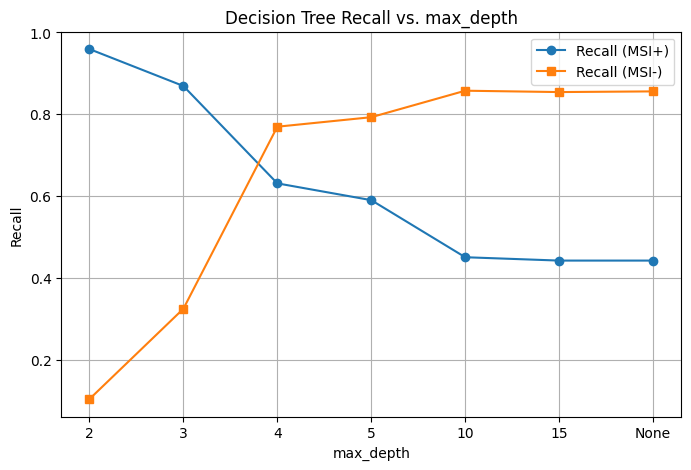


Confusion Matrix for max_depth=2:
[[ 63 540]
 [  5 117]]

Confusion Matrix for max_depth=3:
[[196 407]
 [ 16 106]]

Confusion Matrix for max_depth=4:
[[464 139]
 [ 45  77]]

Confusion Matrix for max_depth=5:
[[478 125]
 [ 50  72]]

Confusion Matrix for max_depth=10:
[[517  86]
 [ 67  55]]

Confusion Matrix for max_depth=15:
[[515  88]
 [ 68  54]]

Confusion Matrix for max_depth=None:
[[516  87]
 [ 68  54]]


In [31]:
# decision tree, varying max_depth
n_folds = 5
max_depth_values = [2, 3, 4, 5, 10, 15, None]

recall_pos_scores = []  # recall for MSI+
recall_neg_scores = []  # recall for MSI- (specificity)
conf_matrices = {}

for depth in max_depth_values:
    y_probs_all = []
    y_true_all = []

    for fold in range(n_folds):
        fold_key = f"fold_{fold}"
        X_train = folds[fold_key]["train"]["X"]
        y_train = folds[fold_key]["train"]["y"]

        X_val = folds[fold_key]["val"]["X"]
        y_val = folds[fold_key]["val"]["y"]

        dt = DecisionTreeClassifier(max_depth=depth, class_weight="balanced", random_state=42)
        dt.fit(X_train, y_train)

        y_prob = dt.predict_proba(X_val)[:, 1]  # probability of MSI+
        y_probs_all.append(y_prob)
        y_true_all.append(y_val)

    # concatenate all folds for averaging
    y_probs_all = np.concatenate(y_probs_all)
    y_true_all = np.concatenate(y_true_all)
    
    # apply decision threshold
    y_pred_avg = (y_probs_all >= 0.1).astype(int)

    # compute recall for positive (MSI+) and negative (MSI-)
    recall_pos = recall_score(y_true_all, y_pred_avg, pos_label=1)
    recall_neg = recall_score(y_true_all, y_pred_avg, pos_label=0)

    recall_pos_scores.append(recall_pos)
    recall_neg_scores.append(recall_neg)

    # save confusion matrix for later inspection
    conf_matrices[depth] = confusion_matrix(y_true_all, y_pred_avg)

# Plot recall curves
plt.figure(figsize=(8, 5))
plt.plot([str(d) for d in max_depth_values], recall_pos_scores, marker="o", label="Recall (MSI+)")
plt.plot([str(d) for d in max_depth_values], recall_neg_scores, marker="s", label="Recall (MSI-)")
plt.xlabel("max_depth")
plt.ylabel("Recall")
plt.title("Decision Tree Recall vs. max_depth")
plt.legend()
plt.grid(True)
plt.show()

# Example confusion matrices at shallow vs deep trees
for depth in max_depth_values:
    print(f"\nConfusion Matrix for max_depth={depth}:")
    print(conf_matrices[depth])

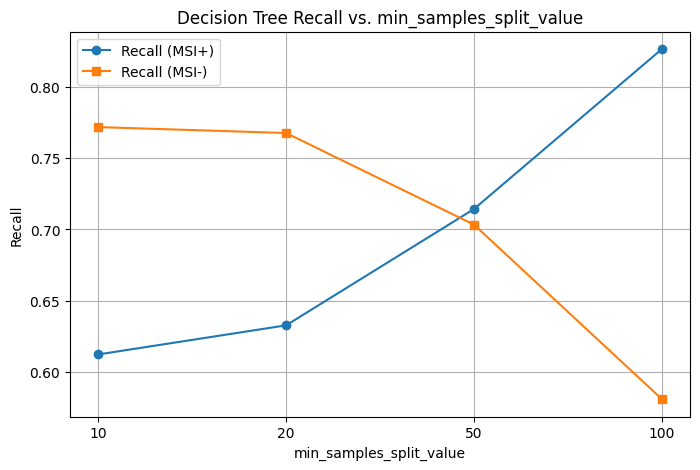


Confusion Matrix for min_samples_split_value=10:
[[372 110]
 [ 38  60]]

Confusion Matrix for min_samples_split_value=20:
[[370 112]
 [ 36  62]]

Confusion Matrix for min_samples_split_value=50:
[[339 143]
 [ 28  70]]

Confusion Matrix for min_samples_split_value=100:
[[280 202]
 [ 17  81]]


In [32]:
# decision tree, varying min_samples_split, max_depth= 4
n_folds = 4
min_samples_split_values = [10, 20, 50, 100]

recall_pos_scores = []  # recall for MSI+
recall_neg_scores = []  # recall for MSI- (specificity)
conf_matrices = {}

for min_samples_split_value in min_samples_split_values:
    y_probs_all = []
    y_true_all = []

    for fold in range(n_folds):
        fold_key = f"fold_{fold}"
        X_train = folds[fold_key]["train"]["X"]
        y_train = folds[fold_key]["train"]["y"]

        X_val = folds[fold_key]["val"]["X"]
        y_val = folds[fold_key]["val"]["y"]

        dt = DecisionTreeClassifier(max_depth=4, min_samples_split= min_samples_split_value, class_weight="balanced", random_state=42)
        dt.fit(X_train, y_train)

        y_prob = dt.predict_proba(X_val)[:, 1]  # probability of MSI+
        y_probs_all.append(y_prob)
        y_true_all.append(y_val)

    # concatenate all folds for averaging
    y_probs_all = np.concatenate(y_probs_all)
    y_true_all = np.concatenate(y_true_all)
    
    # apply decision threshold
    y_pred_avg = (y_probs_all >= 0.1).astype(int)

    # compute recall for positive (MSI+) and negative (MSI-)
    recall_pos = recall_score(y_true_all, y_pred_avg, pos_label=1)
    recall_neg = recall_score(y_true_all, y_pred_avg, pos_label=0)

    recall_pos_scores.append(recall_pos)
    recall_neg_scores.append(recall_neg)

    # save confusion matrix for later inspection
    conf_matrices[min_samples_split_value] = confusion_matrix(y_true_all, y_pred_avg)

# Plot recall curves
plt.figure(figsize=(8, 5))
plt.plot([str(d) for d in min_samples_split_values], recall_pos_scores, marker="o", label="Recall (MSI+)")
plt.plot([str(d) for d in min_samples_split_values], recall_neg_scores, marker="s", label="Recall (MSI-)")
plt.xlabel("min_samples_split_value")
plt.ylabel("Recall")
plt.title("Decision Tree Recall vs. min_samples_split_value")
plt.legend()
plt.grid(True)
plt.show()

# Example confusion matrices at shallow vs deep trees
for min_samples_split_value in min_samples_split_values:
    print(f"\nConfusion Matrix for min_samples_split_value={min_samples_split_value}:")
    print(conf_matrices[min_samples_split_value])

In [33]:
# decision tree, retraining and testing on test set
X_train_full = np.concatenate([folds[f"fold_{i}"]["train"]["X"] for i in range(n_folds)], axis=0)
y_train_full = np.concatenate([folds[f"fold_{i}"]["train"]["y"] for i in range(n_folds)], axis=0)

# 2️⃣ Train the final model on all training data
final_model = DecisionTreeClassifier(max_depth=4, min_samples_split= 50, class_weight="balanced", random_state=42)
final_model.fit(X_train_full, y_train_full)

# 3️⃣ Evaluate on the hold-out test set
X_test = test["X"]
y_test = test["y"]

y_prob_test = final_model.predict_proba(X_test)[:, 1]
y_pred_test = (y_prob_test >= 0.1).astype(int)  # threshold can be adjusted

# 4️⃣ Metrics
print("Final Model Evaluation on Hold-out Test Set")
print(f"Accuracy: {accuracy_score(y_test, y_pred_test):.3f}")
print(f"ROC-AUC:  {roc_auc_score(y_test, y_prob_test):.3f}")
print(f"Recall (MSI+): {recall_score(y_test, y_pred_test, pos_label=1):.3f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_test))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test))

Final Model Evaluation on Hold-out Test Set
Accuracy: 0.621
ROC-AUC:  0.727
Recall (MSI+): 0.774

Confusion Matrix:
[[89 62]
 [ 7 24]]

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.59      0.72       151
           1       0.28      0.77      0.41        31

    accuracy                           0.62       182
   macro avg       0.60      0.68      0.57       182
weighted avg       0.82      0.62      0.67       182



In [38]:
# mlp
n_folds= 5
X_train = np.concatenate([folds[f"fold_{i}"]["train"]["X"] for i in range(n_folds)], axis=0)
y_train = np.concatenate([folds[f"fold_{i}"]["train"]["y"] for i in range(n_folds)], axis=0)
X_val = folds["fold_0"]["val"]["X"]
y_val = folds["fold_0"]["val"]["y"]
X_test = test["X"]
y_test = test["y"]
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_val_t   = torch.tensor(X_val, dtype=torch.float32)
y_val_t   = torch.tensor(y_val, dtype=torch.long)
X_test_t  = torch.tensor(X_test, dtype=torch.float32)
y_test_t  = torch.tensor(y_test, dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=32, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val_t, y_val_t), batch_size=64)
test_loader  = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=64)

# ----- 2. Define a simple MLP -----
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, dropout=0.5):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim//2, 2)   # binary classification (2 outputs for softmax)
        )

    def forward(self, x):
        return self.net(x)

model = MLP(input_dim=X_train.shape[1]).to(device)
labels = torch.tensor(y_train) if not torch.is_tensor(y_train) else y_train
class_counts = torch.bincount(labels)
class_weights = 1.0 / class_counts.float()   # inverse frequency weighting
class_weights = class_weights / class_weights.sum()  # normalize (optional)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# ----- 3. Training loop -----
def train(model, train_loader, val_loader, epochs):
    all_train_loss, all_val_loss = [], []
    all_val_acc, all_recall_pos, all_recall_neg = [], [], []

    for epoch in range(epochs):
        # ---- Training ----
        model.train()
        total_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_train_loss = total_loss / len(train_loader)
        all_train_loss.append(avg_train_loss)

        # ---- Validation ----
        model.eval()
        val_loss = 0
        y_true, y_pred = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                out = model(xb)
                loss = criterion(out, yb)
                val_loss += loss.item()
                preds = out.argmax(dim=1)
                y_true.extend(yb.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        all_val_loss.append(avg_val_loss)

        acc = accuracy_score(y_true, y_pred)
        recall_pos = recall_score(y_true, y_pred, pos_label=1)  # MSI+
        recall_neg = recall_score(y_true, y_pred, pos_label=0)  # MSI–

        all_val_acc.append(acc)
        all_recall_pos.append(recall_pos)
        all_recall_neg.append(recall_neg)

        print(f"Epoch {epoch+1}, "
              f"Train loss {avg_train_loss:.4f}, "
              f"Val loss {avg_val_loss:.4f}, "
              f"Val acc {acc:.3f}, "
              f"Recall(MSI+) {recall_pos:.3f}, "
              f"Recall(MSI–) {recall_neg:.3f}")

    return all_train_loss, all_val_loss, all_val_acc, all_recall_pos, all_recall_neg

# ----- 4. Evaluate on test set -----
def evaluate(model, test_loader, thresholds):
    model.eval()
    y_true, y_pred, y_prob = [], [], []

    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)

            out = model(xb)
            preds = out.argmax(dim=1)
            probs = torch.softmax(out, dim=1)[:, 1]

            y_true.extend(yb.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_prob.extend(probs.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_prob = np.array(y_prob)

    # ---- metrics across custom thresholds ----
    for t in thresholds:
        print(f"\n=== Evaluation at threshold {t:.2f} ===")
        y_pred_t = (y_prob >= t).astype(int)

        acc = accuracy_score(y_true, y_pred_t)
        recall_pos = recall_score(y_true, y_pred_t, pos_label=1)
        recall_neg = recall_score(y_true, y_pred_t, pos_label=0)

        print(f"Accuracy: {acc:.3f}")
        print(f"Recall (MSI+): {recall_pos:.3f}")
        print(f"Recall (MSI–): {recall_neg:.3f}")
        print("\nConfusion Matrix:")
        print(confusion_matrix(y_true, y_pred_t))
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred_t))

    return y_true, y_pred, y_prob
train_loss, val_loss, val_acc, recall_pos, recall_neg = train(model, train_loader, val_loader, epochs=30)

Epoch 1, Train loss 0.5381, Val loss 0.3632, Val acc 0.917, Recall(MSI+) 0.840, Recall(MSI–) 0.933
Epoch 2, Train loss 0.3468, Val loss 0.3582, Val acc 0.938, Recall(MSI+) 0.880, Recall(MSI–) 0.950
Epoch 3, Train loss 0.2834, Val loss 0.2885, Val acc 0.952, Recall(MSI+) 0.880, Recall(MSI–) 0.967
Epoch 4, Train loss 0.2619, Val loss 0.2484, Val acc 0.979, Recall(MSI+) 0.920, Recall(MSI–) 0.992
Epoch 5, Train loss 0.1990, Val loss 0.1272, Val acc 0.945, Recall(MSI+) 0.960, Recall(MSI–) 0.942
Epoch 6, Train loss 0.1705, Val loss 0.1125, Val acc 0.979, Recall(MSI+) 0.960, Recall(MSI–) 0.983
Epoch 7, Train loss 0.1634, Val loss 0.0755, Val acc 0.972, Recall(MSI+) 0.960, Recall(MSI–) 0.975
Epoch 8, Train loss 0.1033, Val loss 0.0993, Val acc 0.986, Recall(MSI+) 0.920, Recall(MSI–) 1.000
Epoch 9, Train loss 0.1056, Val loss 0.0448, Val acc 0.972, Recall(MSI+) 0.960, Recall(MSI–) 0.975
Epoch 10, Train loss 0.1038, Val loss 0.0567, Val acc 0.979, Recall(MSI+) 0.960, Recall(MSI–) 0.983
Epoch 11,

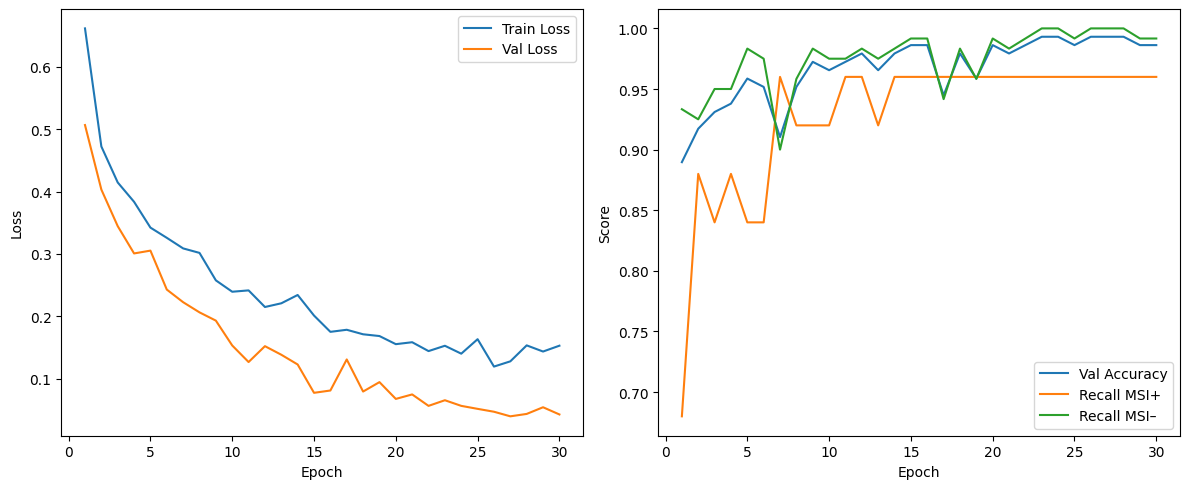

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Loss curves
axs[0].plot(range(1, len(train_loss)+1), train_loss, label="Train Loss")
axs[0].plot(range(1, len(val_loss)+1), val_loss, label="Val Loss")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()

# Accuracy & Recalls
axs[1].plot(range(1, len(val_acc)+1), val_acc, label="Val Accuracy")
axs[1].plot(range(1, len(recall_pos)+1), recall_pos, label="Recall MSI+")
axs[1].plot(range(1, len(recall_neg)+1), recall_neg, label="Recall MSI–")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Score")
axs[1].legend()

plt.tight_layout()
plt.show()

In [39]:
y_test, y_pred_test, y_prob_test = evaluate(model, test_loader, [0.15, 0.2, 0.35])


=== Evaluation at threshold 0.15 ===
Accuracy: 0.846
Recall (MSI+): 0.645
Recall (MSI–): 0.887

Confusion Matrix:
[[134  17]
 [ 11  20]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.89      0.91       151
           1       0.54      0.65      0.59        31

    accuracy                           0.85       182
   macro avg       0.73      0.77      0.75       182
weighted avg       0.86      0.85      0.85       182


=== Evaluation at threshold 0.20 ===
Accuracy: 0.852
Recall (MSI+): 0.645
Recall (MSI–): 0.894

Confusion Matrix:
[[135  16]
 [ 11  20]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.89      0.91       151
           1       0.56      0.65      0.60        31

    accuracy                           0.85       182
   macro avg       0.74      0.77      0.75       182
weighted avg       0.86      0.85      0.86       182


=== Evaluation at thr

In [30]:
def inspect_h5(h5_path, max_print=20):
    with h5py.File(h5_path, "r") as f:
        print("Top-level groups:", list(f.keys()))
        for top in f.keys():
            print(f"\n=== Group: {top} ===")
            grp = f[top]
            # if fold-like, list splits; if test, cores live directly under it
            subkeys = list(grp.keys())
            print(" Subkeys:", subkeys[:max_print], " (showing up to", max_print, ")")
            # show a few cores and their key types/attrs/shapes
            count = 0
            for k in subkeys:
                if count >= max_print:
                    break
                # k is the key as returned by h5py (usually str, but might be bytes)
                print("  Key repr:", repr(k), " type:", type(k))
                try:
                    subgrp = grp[k]
                except Exception as e:
                    print("   -> can't open subgrp:", e)
                    continue
                # if this subgrp itself contains cores (folds), go one level deeper
                if "features" not in subgrp and len(list(subgrp.keys()))>0:
                    # show first inner key
                    inner_keys = list(subgrp.keys())
                    print("   Inner keys sample:", inner_keys[:3])
                    inner = subgrp[inner_keys[0]]
                    print("    attributes:", dict(inner.attrs))
                    if "features" in inner:
                        print("    features shape:", tuple(inner["features"].shape))
                else:
                    # subgrp looks like a core
                    print("   attributes:", dict(subgrp.attrs))
                    if "features" in subgrp:
                        print("   features shape:", tuple(subgrp["features"].shape))
                count += 1

inspect_h5("mean_aggregated_features.h5")

Top-level groups: ['fold_0', 'fold_1', 'fold_2', 'fold_3', 'fold_4', 'test']

=== Group: fold_0 ===
 Subkeys: ['train', 'val']  (showing up to 20 )
  Key repr: 'train'  type: <class 'str'>
   Inner keys sample: ['10', '101', '102']
    attributes: {'num_cores': 4}
    features shape: (1024,)
  Key repr: 'val'  type: <class 'str'>
   Inner keys sample: ['113', '114', '1179']
    attributes: {'num_cores': 4}
    features shape: (1024,)

=== Group: fold_1 ===
 Subkeys: ['train', 'val']  (showing up to 20 )
  Key repr: 'train'  type: <class 'str'>
   Inner keys sample: ['10', '101', '102']
    attributes: {'num_cores': 4}
    features shape: (1024,)
  Key repr: 'val'  type: <class 'str'>
   Inner keys sample: ['106', '110', '115']
    attributes: {'num_cores': 2}
    features shape: (1024,)

=== Group: fold_2 ===
 Subkeys: ['train', 'val']  (showing up to 20 )
  Key repr: 'train'  type: <class 'str'>
   Inner keys sample: ['10', '101', '102']
    attributes: {'num_cores': 4}
    features s

In [43]:
# patch h5 file preview
hdf5_path= "/home/jantao/MSI_prediction/better_patches.h5"
with h5py.File(hdf5_path, "r") as f:
    def print_h5_structure(name, obj):
        print(name, "->", type(obj))
    #f.visititems(print_h5_structure)
    train_group= f["fold_0/train"]
    for core_name in train_group.keys():
        core_group= train_group[core_name]
        patches = core_group["patches"][:]  # numpy array
        coords  = core_group["coords"][:]
        print(f"Core: {core_name}, patches shape: {patches.shape}, first coords: {coords[:5]}")
        print(f"Tumor ID: {core_group.attrs['tumor']}, original image: {core_group.attrs['original_image']}")
    print(list(train_group.keys()))

Core: TMA 1 Level 16_Core[1,1,10]_[4381,47584], patches shape: (27, 224, 224, 3), first coords: [[448   0]
 [224 224]
 [448 224]
 [672 224]
 [896 224]]
Tumor ID: 82, original image: TMA 1 Level 16_Core[1,1,10]_[4381,47584].tif
Core: TMA 1 Level 16_Core[1,1,13]_[4110,50255], patches shape: (27, 224, 224, 3), first coords: [[ 224  224]
 [ 448  224]
 [ 672  224]
 [ 896  224]
 [1120  224]]
Tumor ID: 104, original image: TMA 1 Level 16_Core[1,1,13]_[4110,50255].tif
Core: TMA 1 Level 16_Core[1,1,14]_[4258,50948], patches shape: (22, 224, 224, 3), first coords: [[224 224]
 [448 224]
 [896 224]
 [  0 448]
 [224 448]]
Tumor ID: 110, original image: TMA 1 Level 16_Core[1,1,14]_[4258,50948].tif
Core: TMA 1 Level 16_Core[1,1,16]_[4258,52456], patches shape: (29, 224, 224, 3), first coords: [[448   0]
 [  0 224]
 [224 224]
 [448 224]
 [672 224]]
Tumor ID: 124, original image: TMA 1 Level 16_Core[1,1,16]_[4258,52456].tif
Core: TMA 1 Level 16_Core[1,1,17]_[4270,53098], patches shape: (28, 224, 224, 3

KeyboardInterrupt: 

In [12]:
# features h5 file check
def find_missing_attrs(h5_path, count=0):
    with h5py.File(h5_path, "r") as f:
        for group_key in f.keys():  # fold_0, fold_1, ..., test
            group = f[group_key]
            for sub_key in group.keys():  # train/val for folds, cores for test
                sub_group = group[sub_key]
                # If this is the test group, cores are directly under it
                if group_key == "test":
                    core_groups = [sub_group]
                    names = [sub_key]
                else:
                    core_groups = [sub_group[k] for k in sub_group.keys()]
                    names = list(sub_group.keys())
                for core_group, core_name in zip(core_groups, names):
                    if "tumor" not in core_group.attrs:
                        count += 1
                        print(f"Missing 'tumor' in {group_key}/{sub_key}/{core_name}")
                        for attr_name, attr_value in core_group.attrs.items():
                            print(f"  {attr_name}: {attr_value}")
    return count

count = find_missing_attrs("features.h5")
print(f"Total missing 'tumor': {count}")

Total missing 'tumor': 0


Original image size: (1460, 1460)
Extracted 49 patches of size (224, 224)


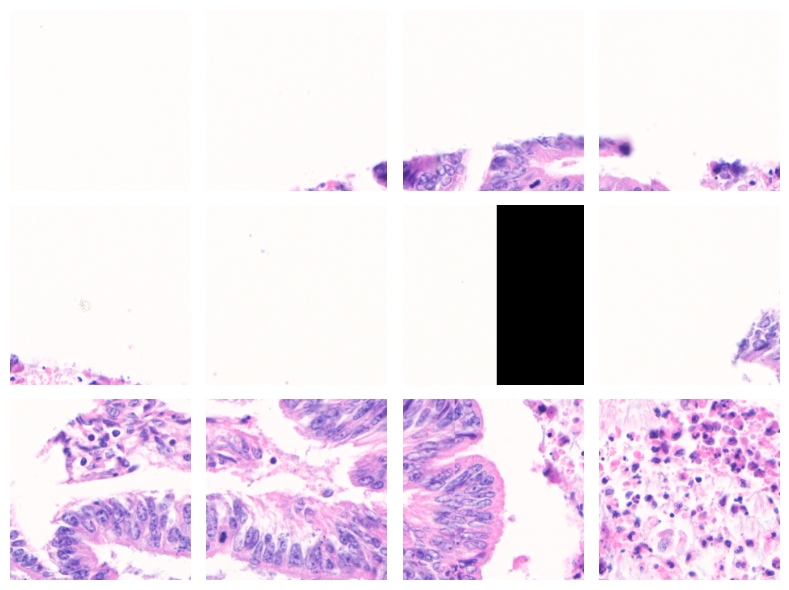

In [5]:
# inspecting images
patch_size = (224, 224)

image_path = os.path.join(folder_path, "HE_raw_images/Tumor/TMA1")
files = [f for f in sorted(os.listdir(image_path)) if f.endswith(".tif")][:1]  # just pick one image

for file in files:
    full_path = os.path.join(image_path, file)
    im = Image.open(full_path)
    print("Original image size:", im.size)

    # break into patches
    patches = []
    w, h = im.size
    pw, ph = patch_size
    for y in range(0, h, ph):
        for x in range(0, w, pw):
            patch = im.crop((x, y, x+pw, y+ph))
            patches.append(patch)

    print(f"Extracted {len(patches)} patches of size {patch_size}")

    # show the first few patches
    n_show = 12
    fig, axes = plt.subplots(3, 4, figsize=(8,6))
    for ax, patch in zip(axes.flat, patches[:n_show]):
        ax.imshow(patch)
        ax.axis("off")
    plt.tight_layout()
    plt.show()